# Data 2040 Project

## Name: Hangyu Liu

# Download LFW data and Data Preprocessing

When I download and unzip the LFW file (All Images as gzipped tar file 173 MB) from http://vis-www.cs.umass.edu/lfw/, I found that there is a subfolder for every different person (identity), which is inconvenient for me to do futher processing, so I used bash command to handle this problem.   

First, I need to move all image files from subfolder to parent folder by using the following code:   
find . -mindepth 2 -type f -print -exec mv {} . \;   

Next, I need to delete all empty folders with the following code:   
find . -empty -type d -delete  

And then, I extract all images file names and save them in a .csv file:   
printf '%s,' *.jpg > name.csv

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
PATH = './lfw/'
image_name = pd.read_csv('name.csv',header = None)

In [3]:
image_name.head(10)

,0
0,AJ_Cook_0001.jpg
1,AJ_Lamas_0001.jpg
2,Aaron_Eckhart_0001.jpg
3,Aaron_Guiel_0001.jpg
4,Aaron_Patterson_0001.jpg
5,Aaron_Peirsol_0001.jpg
6,Aaron_Peirsol_0002.jpg
7,Aaron_Peirsol_0003.jpg
8,Aaron_Peirsol_0004.jpg
9,Aaron_Pena_0001.jpg


In [4]:
print(image_name.shape)

(13233, 1)


In [5]:
# change the names data frame into numpy array
image_names = image_name[0].values

In [6]:
# Get the label of each image
labels = np.array([name[:-9] for name in image_names])

In [7]:
image_array = []
for name in image_names:
    img = image.load_img(PATH + name, target_size=(250, 250))
    image_array.append(image.img_to_array(img))
image_array = np.array(image_array)

In [8]:
image_array.shape

(13233, 250, 250, 3)

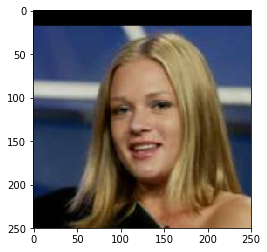

In [9]:
plt.imshow(image_array[0]/255.)

# Customized Sub-Dataset

As we can see, there are 13233 images in the LFW data, which is too much. And here we are trying to replicate the works in the paper and verify corresponding results, so I will select a subset of LFW dataset to use, which contains 100 face images of 10 people: Ariel_Sharon, Arnold_Schwarzenegger, Colin_Powell, Donald_Rumsfeld, George_W_Bush, Gerhard_Schroeder, Hugo_Chavez, Jacques_Chirac, Tony_Blair and Vladimir_Putin.

In [10]:
chosen_identity = ['Ariel_Sharon', 'Arnold_Schwarzenegger', 'Colin_Powell', 'Donald_Rumsfeld',\
                   'George_W_Bush', 'Gerhard_Schroeder', 'Hugo_Chavez', 'Jacques_Chirac',\
                   'Tony_Blair', 'Vladimir_Putin']
cus_images = image_array[labels == 'Ariel_Sharon'][:10]
for name in chosen_identity:
    if name == 'Ariel_Sharon':
        continue
    cus_images = np.vstack((cus_images, image_array[labels == name][:10]))

In [11]:
cus_images.shape

(100, 250, 250, 3)

# Face Alignment

One thing that plays essential role on the performance of network is face alignment. We need to ensure that faces are aligned before they are feeded into the deep neural network, which is a very important preprocessing step. Here, I will use AlignDlib utility (From OpenCV project) for face detection and OpenCV for image transformation and croping to produce aligned 96*96 face images. This step is based on Martin krasser' blog: http://krasserm.github.io/2018/02/07/deep-face-recognition/

In [12]:
import matplotlib.patches as patches
import cv2
from align import AlignDlib

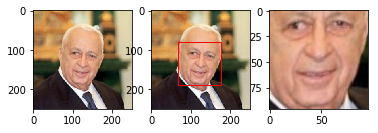

In [13]:
# Initialize the OpenFace face alignment utility
# I will use 'dlib.face.landmarks.dat' as my face predictor
alignment = AlignDlib('pyannote-data-master/dlib.face.landmarks.dat')

# Detect face and return bounding box
as_orig = cus_images[0].astype('uint8')
bb = alignment.getLargestFaceBoundingBox(as_orig)

# Transform image using specified face landmark indices and crop image to 96x96
as_aligned = alignment.align(96, as_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(as_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(as_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(as_aligned)

In [14]:
# As above experiment shows, the face alignment has good performance, thus we can write a 
# reusable alignment function:
def align_image(img):
    img = img.astype('uint8')
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [15]:
# And then align all images in the customized dataset
aligned_image = align_image(cus_images[0]).reshape(1,96,96,3)

for i in range(1,len(cus_images)):
    try:
        aligned_image = np.vstack((aligned_image, align_image(cus_images[i]).reshape(1,96,96,3)))
    except:
        print('Image {} may not have the front face to be aligned'.format(i))
    
aligned_image.shape

Image 75 may not have the front face to be aligned
Image 79 may not have the front face to be aligned


(98, 96, 96, 3)

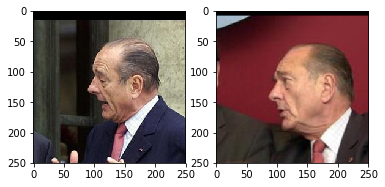

In [16]:
# We take a look at image 75 and image 79
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cus_images[75]/255.)
ax2.imshow(cus_images[79]/255.)

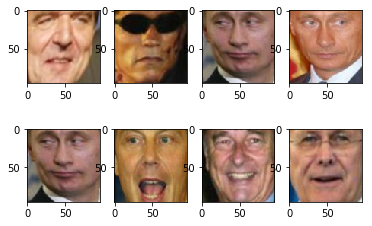

In [17]:
# Finally, we can look at eight random aligned images
np.random.seed(1024)
f, ax = plt.subplots(2, 4)
for row in ax:
    for col in row:
        col.imshow(aligned_image[np.random.randint(0,len(aligned_image))])

As the result shows, I got a pretty well perfomance on face alignment, and next, we can move on to the SiameseNet model building part.

There are 98 images in my aligned cutomized data set, and for the convenience of next analysis, I will save the name of each image in a list:

In [18]:
name_list = []
for name in chosen_identity:
    i = 0
    while i < 10:
        name_list.append(name)
        i += 1

# delete two names for which identity has no front face to be aligned
name_list[75], name_list[79] = None, None
name_list = [name for name in name_list if name is not None]

# Model Building 

SiameseNet model will encode the images to a 128 dim vector that will represent the image. Kind of a signature of the images.   

The fundamental assumption of this model is that same person should have similar "signatures" and I will trian this model with Triplet loss, the logic can be shown as the following picture: (Golbstein:https://github.com/Golbstein/keras-face-recognition):   

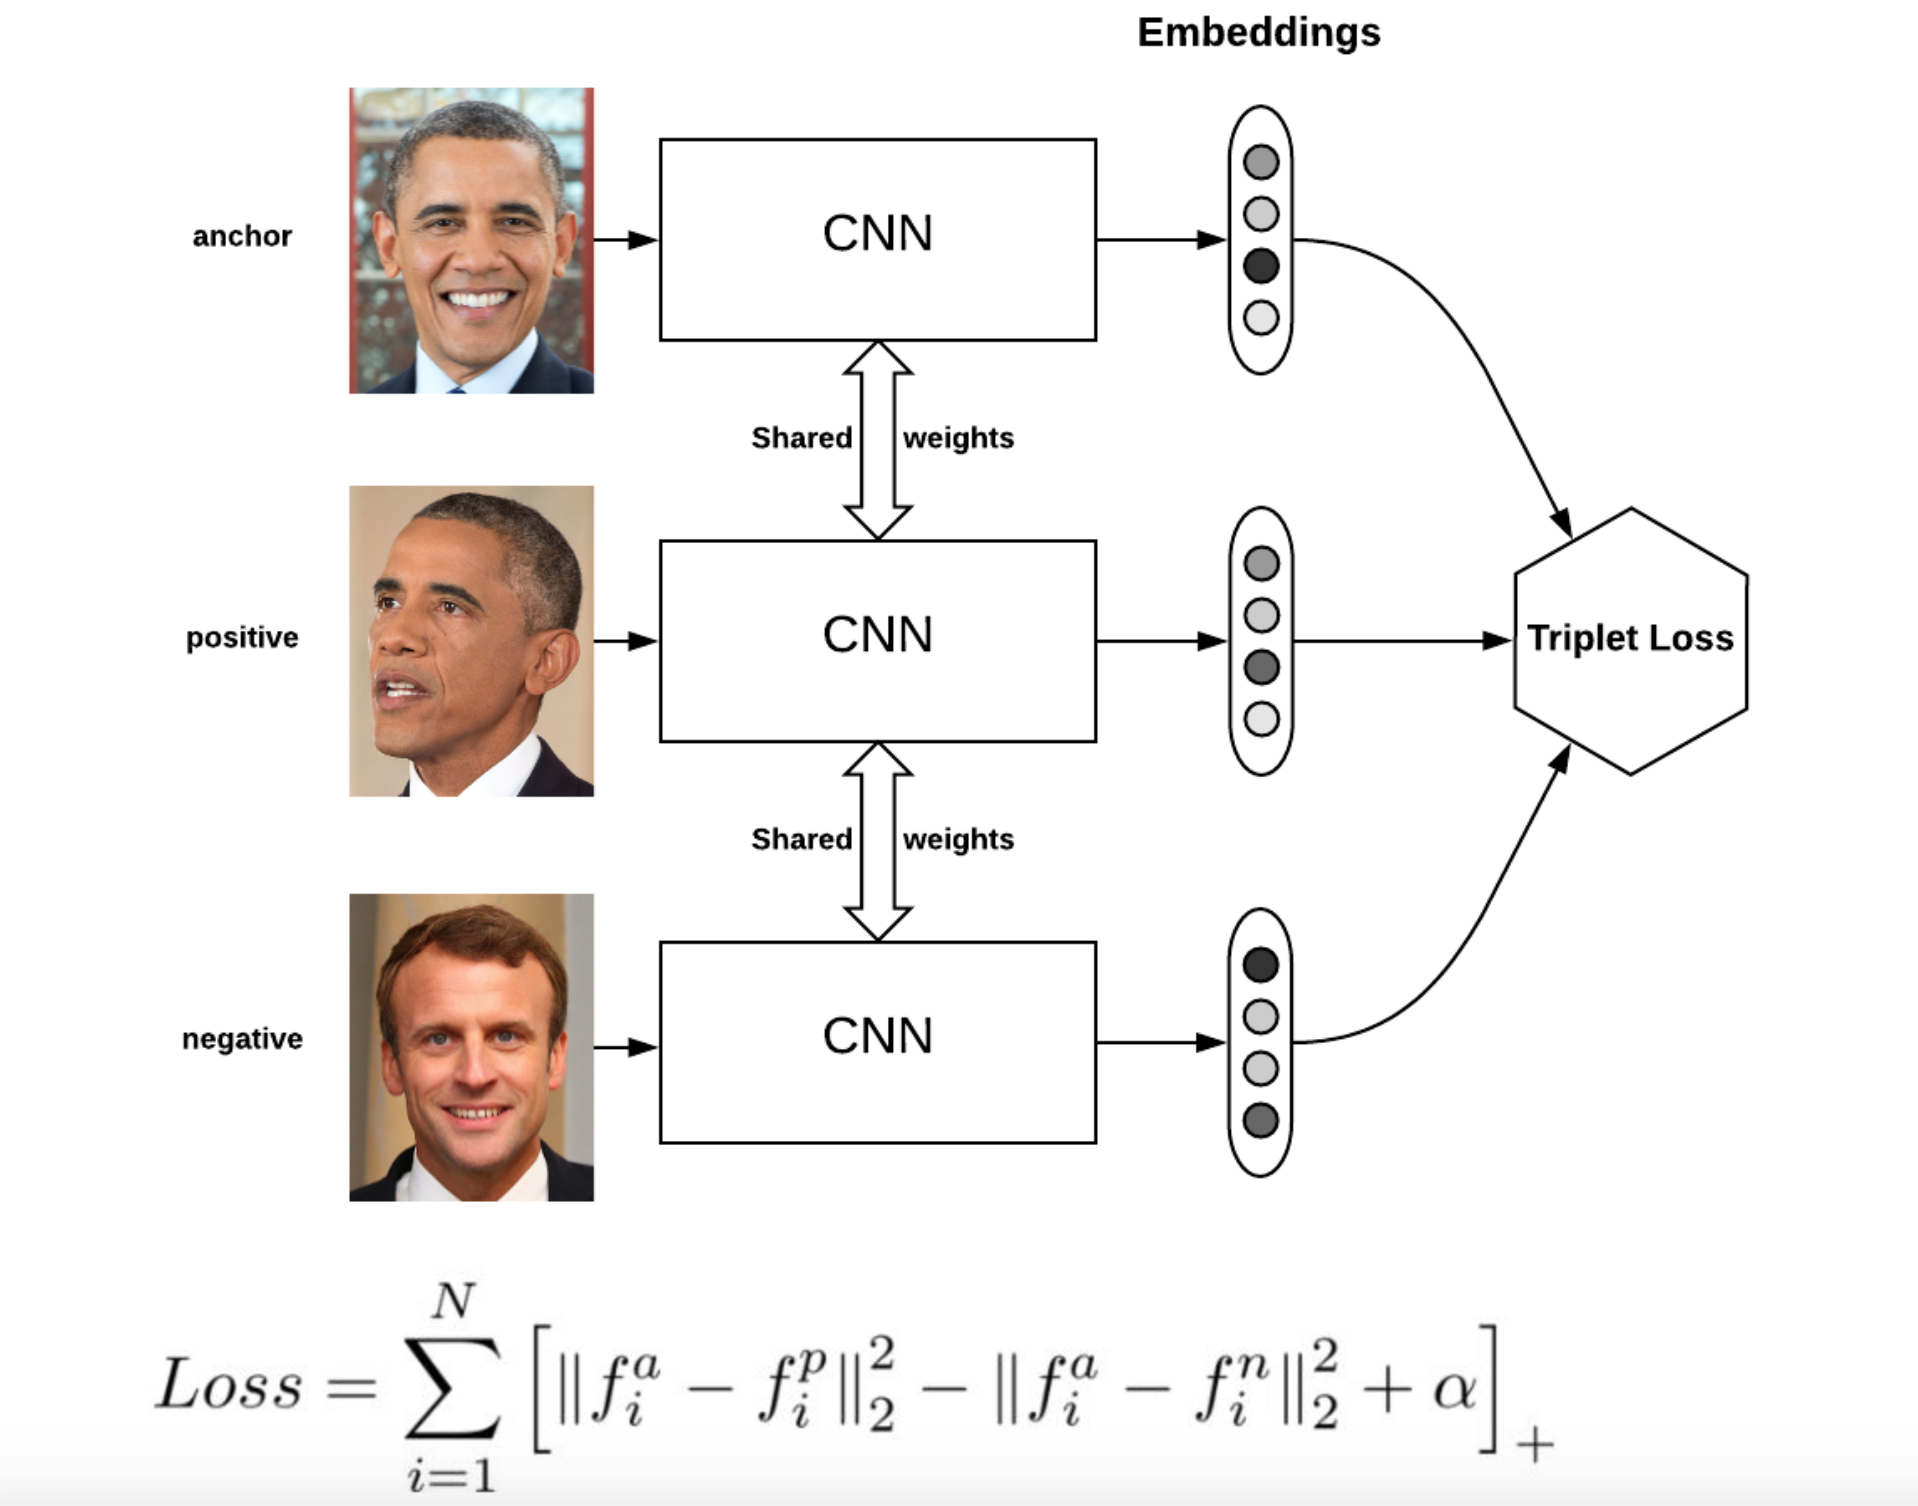

In [19]:
from IPython.display import Image
Image("triplet loss.png")

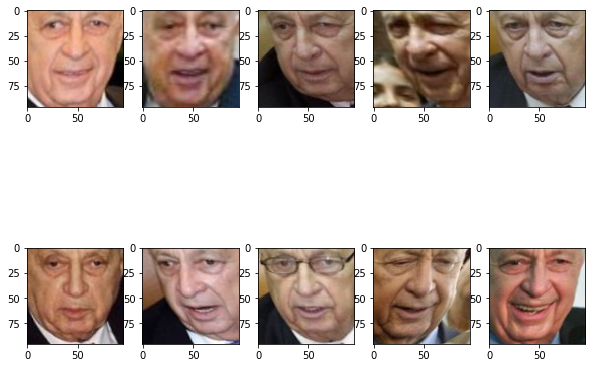

In [20]:
# First we can visualize ten images of the same person (Ariel_Sharon)
f, ax = plt.subplots(2, 5)
f.set_size_inches(10,8)
i = 0
for row in ax:
    for col in row:
        col.imshow(aligned_image[i])
        i += 1

The CNN architecture used here is a variant of NN4 architecture described in paper 'FaceNet: A Unified Embedding for Face Recognition and Clustering', and it is named as 'nn4.small2' model in the OpenFace: https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions, which has 3733968 parameters and it is smaller than 'nn4' in paper with 6959088 parameters. Specifically, it is the FaceNet's NN4 network with 4b, 4c, and 4d layers removed
and smaller 5 layers. The following is corresponding implementation provided by OpenCV:
https://github.com/cmusatyalab/openface/blob/master/models/openface/nn4.small2.def.lua   

In [21]:
from model import create_model
nn4_small2 = create_model()

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
nn4_small2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [23]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

Rather than training this model from scratch, I will use pre-trained model provided by OpenFace, which was trained on datasets FaceScrub http://vintage.winklerbros.net/facescrub.html and CASIA-WebFace https://arxiv.org/abs/1411.7923. The reason why I don't train it by myself is that this training process needs a lot of computational resource, which is impossible for me to train it in my computer or CCV. OpenFace provided the 'csv' format wights file:https://github.com/iwantooxxoox/Keras-OpenFace/tree/master/weights and then I used the convert function provided by https://github.com/krasserm/face-recognition/blob/master/face-recognition-convert.ipynb to save it as binary format, which can be loaded by using 'load_weights' function in Keras:

In [24]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('nn4.small2.v1.h5')

Next, we can get the embedding 128-demension vectors:

In [25]:
embedding_vec = np.zeros((aligned_image.shape[0], 128))

In [26]:
for i, m in enumerate(aligned_image):
    # scale RGB values to the interval [0,1]
    img = (m / 255.).astype(np.float32)
    # get embedding vector
    embedding_vec[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

# Face Verification

As the setting in the paper, I would like to use Euclidean distance as the metric to measure the similiarity between two images, and we can check the outcome of embedding vectors obtained by pretrained nn4.small model:

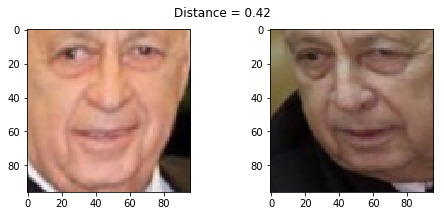

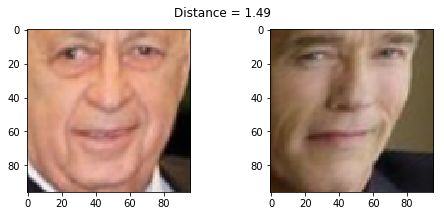

In [27]:
def distance(emb1, emb2):
    return np.sqrt(np.sum(np.square(emb1 - emb2)))


def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedding_vec[idx1], embedding_vec[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(aligned_image[idx1])
    plt.subplot(122)
    plt.imshow(aligned_image[idx2])

    
show_pair(0, 2)
show_pair(0, 12)

As the result shows, the embedding vectors obtained by pretrained nn4.small model has pretty good performance on my customized data set. For face verification task, the same identity's images have significantly smaller distance (0.18) when compared with the distance (2.22) between different identity's images. However, we need to get the threshold to determine between same indentity and different identity. Aiming to get this threshold, we can draw a plot to look at the trend of F-1 score as we try different threshold. The reason why I choose F-1 score here is inspired by the blog: http://krasserm.github.io/2018/02/07/deep-face-recognition/, which points out that the data set here with skewed classes, which means it is pretty imbalanced, so accuracy cannot serve as a suitable evaluation metric here.

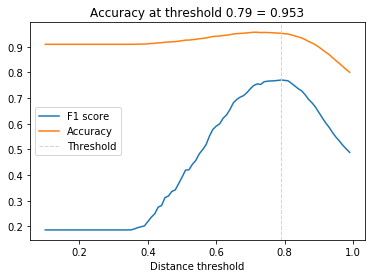

In [28]:
from sklearn.metrics import f1_score, accuracy_score
distances = [] 
identical = [] 
num_of_images = len(aligned_image)

for i in range(num_of_images - 1):
    for j in range(1, num_of_images - 1):
        distances.append(distance(embedding_vec[i], embedding_vec[j]))
        identical.append(1 if name_list[i] == name_list[j] else 0)

distances, identical = np.array(distances), np.array(identical)
thresholds = np.arange(0.1, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
opt_tau = thresholds[opt_idx]
opt_acc = accuracy_score(identical, distances < opt_tau)

plt.plot(thresholds, f1_scores, label='F1 score')
plt.plot(thresholds, acc_scores, label='Accuracy')
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend()

In the paper, the authors proposed two performance metric to evaluate the performace of embedding vector, one is validation rate VAL(d) and false accept rate FAR(d), so we can also check this two evaluation metric here:

In [29]:
p_same = distances[identical == 1]
p_diff = distances[identical == 0]
print(len(p_same))
print(len(p_diff))

935
8377


In [30]:
TA = sum(p_same < opt_tau)
FA = sum(p_diff < opt_tau)
print('The validation rate VAL is {}'.format(TA / len(p_same)))
print('The false accept rate is {}'.format(FA / len(p_diff)))

The validation rate VAL is 0.7925133689839572
The false accept rate is 0.029485496000954996


The benchmark VAL provided by paper for NN4 (Inception 96*96) on LFW is 82.0% ± 2.3. And the VAL obtained by my model is about 79.25%, which lied in the reasonable interval.

# Face Recognition

Since we have already obtained an estimated distance threshold, so one easy way to conduct face recognition is to calculate the distance between input embedding vector and all embedding vectors in the database. If the smallest distance between input embedding vector and vectors in the database is less than the distance threshold, the input embedding vector will be labeled as the identity with smallest distance. Otherwise, it will be labeled as UNKNOW.

Apart from this easy way, we can also conduct KNN to do this face recognition job:

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
targets = np.array(name_list)
encoder = LabelEncoder()
encoder.fit(targets)
# convert the label into the numeric format
y = encoder.transform(targets)
# train-test split
train_idx = np.arange(len(name_list)) % 2 == 0
test_idx = np.arange(len(name_list)) % 2 != 0
X_train, X_test = embedding_vec[train_idx], embedding_vec[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
# model fit
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train, y_train)
# model prediction
acc_knn = accuracy_score(y_test, knn.predict(X_test))
print('The accuracy of face recognization based on KNN is {}'.format(acc_knn))

The accuracy of face recognization based on KNN is 0.9795918367346939


As the result shows, the KNN achieved pretty well performance on test data set, which has about 98% accuracy. And then I would like to use more images in the LFW to check the  performance of my model.

I only choose first ten images of 'George_W_Bush' when I make my customized data set, and there are 530 images of 'George_W_Bush' in the LFW data set, so we can do face recognization task on the remaining 520 images. 

In [32]:
test_Bush_images = image_array[labels =='George_W_Bush'][10:]

aligned_Bush_image = align_image(test_Bush_images[0]).reshape(1,96,96,3)

for i in range(1,len(test_Bush_images)):
    try:
        aligned_Bush_image = np.vstack((aligned_Bush_image, align_image(test_Bush_images[i]).reshape(1,96,96,3)))
    except:
        print('Image {} may not have the front face to be aligned'.format(i))

Image 437 may not have the front face to be aligned


In [33]:
# transform 519 aligned images into embedding vectors:
embedding_Bush_vec = np.zeros((aligned_Bush_image.shape[0], 128))

for i, m in enumerate(aligned_Bush_image):
    # scale RGB values to the interval [0,1]
    img = (m / 255.).astype(np.float32)
    # get embedding vector
    embedding_Bush_vec[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

In [34]:
target_label = np.array([4] * len(aligned_Bush_image))
acc_test = accuracy_score(target_label, knn.predict(embedding_Bush_vec))
print('The face recognization accuracy of KNN in the unseen 519 imgaes of George_W_Bush is {}'\
     .format(acc_test))

The face recognization accuracy of KNN in the unseen 519 imgaes of George_W_Bush is 0.9672447013487476


And we can take a look at a specific image which was classified correctly:

Text(0.5, 1.0, 'Recognized as George_W_Bush')

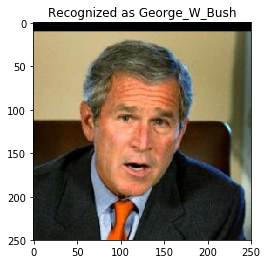

In [35]:
# Make prediction for the one image of Bush
plt.imshow(test_Bush_images[1]/255.)
plt.title('Recognized as {}'.format(chosen_identity[knn.predict(embedding_Bush_vec)[1]]))

And then we can look into details of those images which are misclassified

In [36]:
predict_Bush = knn.predict(embedding_Bush_vec)
misclassified_images = aligned_Bush_image[predict_Bush != 4]
print('There are {} images are misclassified'.format(len(misclassified_images)))

There are 17 images are misclassified


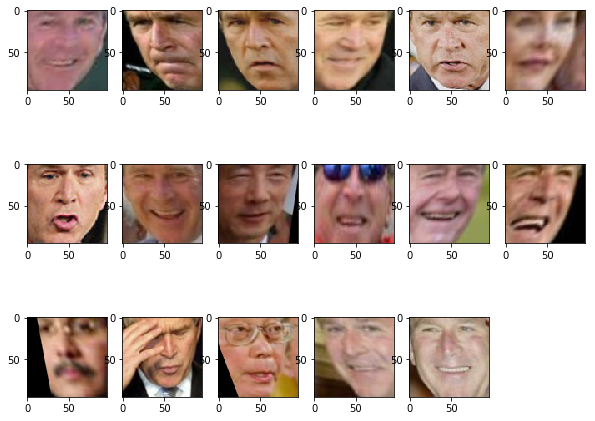

In [37]:
# We can take a look at these 17 images which are misclassified by our model
f, ax = plt.subplots(3, 6)
f.set_size_inches(10,8)
i = 0
for row in ax:
    for col in row:
        if i >= 17:
            break
        col.imshow(misclassified_images[i])
        i += 1
f.delaxes(ax[2][5])

As we can see, there are some images are truly not George_W_Bush (6th image, 9th image, 13th image, 15th image), I think it may be due to the face alignment. Since, there may have more than one face, and the face alignment function captured other's face insead of George_W_Bush. Let us see if it is the case:

In [38]:
# Find the index of images which are misclassified
idx = 0
idx_list = []
for item in predict_Bush != 4:
    if item:
        idx_list.append(idx)
    idx += 1

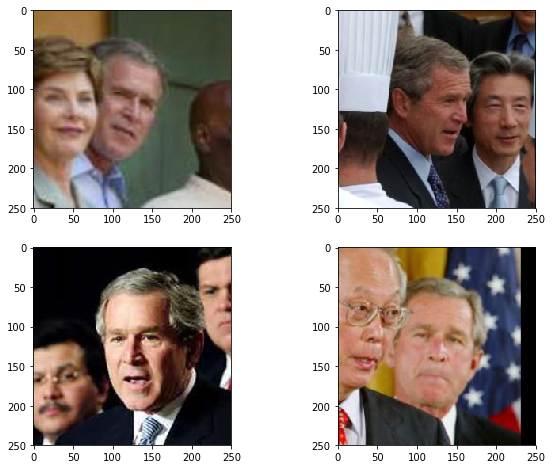

In [39]:
# Show original pictures of misclassified images
f, ax = plt.subplots(2, 2)
f.set_size_inches(10,8)
i_star = [idx_list[5], idx_list[8], idx_list[12], idx_list[14]]
i = 0
for row in ax:
    for col in row:
        if i_star[i] > 437:
            col.imshow(test_Bush_images[i_star[i]+1]/255.)
            break
        col.imshow(test_Bush_images[i_star[i]]/255.)
        i += 1

The results are in accordance with my guess, some misclassification is because there are more than one face in the image, and the face alignment function captures some other's face.

And then, we can try some one's image who is not in our embedding vector database (eg. Donald Trump), in this case, we can find the most similar identity in our data base with the input indentity.

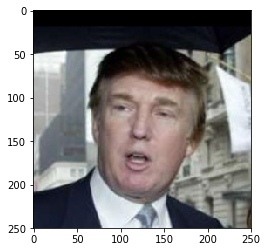

In [41]:
image_Trump = image_array[labels == 'Donald_Trump'][0]
plt.imshow(image_Trump/255.)

In [42]:
# conduct face alignment on this image
aligned_Trump_image = align_image(image_Trump).reshape(1,96,96,3)
# convert image into embedding vector
embedding_Trump_vec = np.zeros((aligned_Trump_image.shape[0], 128))
for i, m in enumerate(aligned_Trump_image):
    # scale RGB values to the interval [0,1]
    img = (m / 255.).astype(np.float32)
    # get embedding vector
    embedding_Trump_vec[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

Firstly, we can use KNN to make a face recognization

Text(0.5, 1.0, 'Recognized as Tony_Blair')

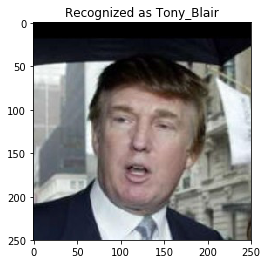

In [44]:
# Make prediction
predict_Trump = knn.predict(embedding_Trump_vec)
plt.imshow(image_Trump/255.)
plt.title('Recognized as {}'.format(chosen_identity[predict_Trump[0]]))

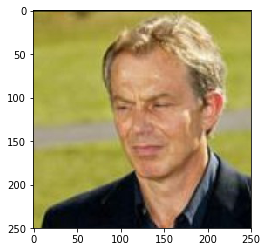

In [45]:
# The image of Tony Blair
plt.imshow(image_array[labels == chosen_identity[predict_Trump[0]]][3]/255.)

As the result shows, Donald Trump was recognized as Tony Blair by my KNN model. It is reasonable, since there is no image of Donald Trump in our image database, so my KNN model can and can only find the most similar one for Donald Trump's image.